# Home Value Prediction

## Project Goals
* Identify key features that can be used to create an effective predictive model.
* Use regression models to make house price predictions.
* Use findings to make recommendations and establish a foundation for future work to improve model's performance.

## Imports

In [1]:
#list all of the imports I used in this notebook or in a module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

#import my personal modules created for this report
import wrangle as w
#import explore as e
#import model as m

## Acquire

* Data acquired from the Codeup mySQL server on November 16, 2022
* It contained 52,441 rows and 6 columns
* Each observation represents a single-family home
* Each column represents a feature of those homes

In [2]:
#import unclean data from Codeup mySQL server
zillow_unclean = w.acquire_zillow_data()

## Prepare

#### Dropped rows:
* Duplicates   
* Rows where ```bedrooms``` == 0 AND ```bathrooms``` == 0
* Rows where ```square_feet``` >= 10,000  (because these are large and can scew the data)
* Rows where ```home_value``` >= 1,600,000 (because these values are large and can scew the data)
* Rows containing null values in any column

#### Created features
* ```county``` (names based on the fips code):  
    - 6037: LA
    - 6059: Orange 
    - 6111: Ventura 
* ```bath_bed_ratio``` 
    - Column displaying bathrooms/bedrooms

#### Other prep
* Split data into train, validate, and test (65/20/15)

In [3]:
#split and prepare the data for exploration and modeling
train_exp, X_train, y_train, \
X_validate, y_validate, \
X_test, y_test = w.big_zillow_wrangle(zillow_unclean, 'home_value')

### Data dictionary
| Feature | Definition | Type |
|:--------|:-----------|:-------
| **bathroooms** | The number of bathrooms in the home. |
| bedrooms | The number of bedrooms in the home. |
|**???**| Definition| *type*|
|**???**| Definition| *type*|
|**???**| Definition| *type*|
|**???**| Definition| *type*|
|**???**| Definition| *type*|
|**Target variable**
|**home_value**| The tax-assessed value of the home. | *float* |

### A look at the data

In [4]:
#show thefirst few rows of the train data
train_exp.head()

,parcelid,bathrooms,bedrooms,home_value,square_feet,year_built,bath_bed_ratio,county
43055,13955676,2.5,3,467000.0,1509,2001,0.833333,Orange
27580,14184733,3.0,5,411581.0,2822,1993,0.600000,Orange
38642,10889898,1.0,2,156917.0,878,1940,0.500000,LA
40986,12579090,2.0,4,264953.0,1620,1964,0.500000,LA
37881,12919161,2.0,4,402200.0,1128,1955,0.500000,LA


## Explore

### 1. Is there a significant relationship between ```square_feet``` and ```home_value```?

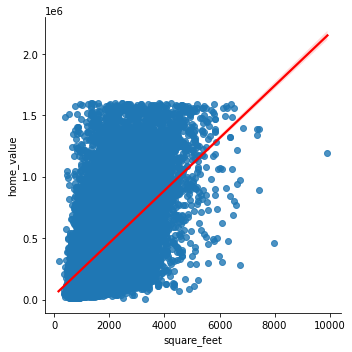

In [11]:
sns.lmplot('square_feet', 'home_value', data=train_exp, line_kws={'color':'red'});

**As suspected, it looks like larger homes have a higher home value**

**Set Hypothesis**

$H_0$ = There is no linear correlation between square feet and home value 

$H_a$ = There is a linear correlation between square feet and home value 

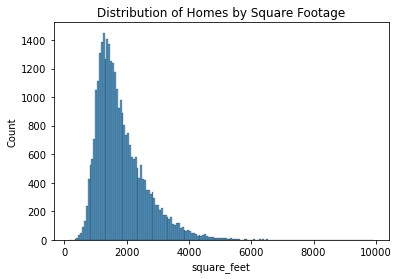

In [23]:
sns.histplot(data = train_exp, x = 'square_feet')
plt.title('Distribution of Homes by Square Footage')
plt.show()

**There is a skewed distribution so I will use the Spearman's R test**

In [16]:
#run spearman test to see if there is any linear correlation
corr, p = stats.spearmanr(train_exp.square_feet, train_exp.home_value)
#Running a significance test to determine whether we can reject the null:

#print results
print(f"Correlation Coefficient: {corr:.8}\np-value: {p:.4}")

Correlation Coefficient: 0.47922062
p-value: 0.0


**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between square feet and home value, but not a very strong one.** 

## 2. Is there a significant relationship between ```bath_bed_ratio``` and ```home_value```? 

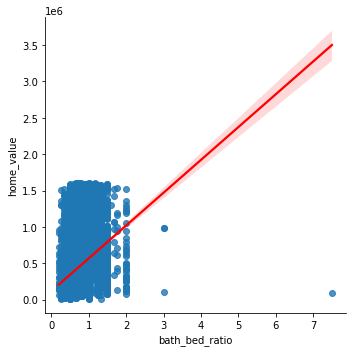

In [17]:
sns.lmplot('bath_bed_ratio', 'home_value', data=train_exp, line_kws={'color':'red'});

**It looks like there is a linear correlation between bath_bed_ratio and home value**

**Set Hypothesis**

$H_0$ = There is no linear correlation between bath_bed_ratio and home value 

$H_a$ = There is a linear correlation between bath_bed_ratio and home value 

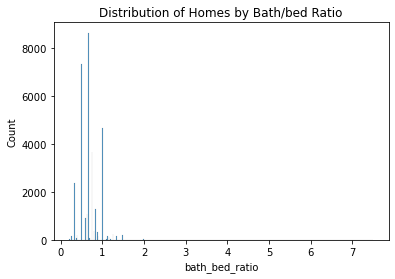

In [24]:
sns.histplot(data = train_exp, x = 'bath_bed_ratio')
plt.title('Distribution of Homes by Bath/bed Ratio')
plt.show()

In [21]:
#run spearman test to see if there is any linear correlation
corr, p = stats.spearmanr(train_exp.bath_bed_ratio, train_exp.home_value)
#Running a significance test to determine whether we can reject the null:

#print results
print(f"Correlation Coefficient: {corr:.8}\np-value: {p:.4}")

Correlation Coefficient: 0.32081477
p-value: 0.0


**p < alpha, so we can reject the null hypothesis and say there is probably a a linear correlation between bath_bed_ratio and home value.** 

## 3. Does location have a relationship with ```home_value```?

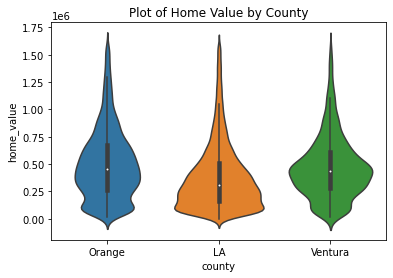

In [19]:
sns.violinplot(data = train_exp, x = 'county', y = 'home_value' )
plt.title('Plot of Home Value by County')
plt.show()

**From the visualization, I can't tell if there is any difference in home value across the three counties.**

$H_0$ = Average home values of those in LA county, Orange county and Ventura county are the same.

$H_a$ = Average home values of those in LA county, Orange county and Ventura county are not the same.

In [25]:
#splitting data into a df per county:
la = train_exp[train_exp.county == 'LA'].home_value
orange = train_exp[train_exp.county == 'Orange'].home_value
ventura = train_exp[train_exp.county == 'Ventura'].home_value

#Running a one-way ANOVA (there is a single independent variable - 'county'):
f, p = stats.f_oneway(la, orange, ventura)

print(f"F-score: {f:.8}\np-value: {p:.4}")

F-score: 495.59484
p-value: 9.732e-213


**Since t > 0 and p/2 < alpha we can reject the null hypothesis and say monthly charges of those who churn are higher than those who don't churn.**

***Based on the visualizations and the results from the T-test, I think that monthly charges should be used in my model to help with the model's accuracy.***

## 4. Does contract type affect churn?

In [ ]:
#plot different contract types compared to churn
e.contract_type_viz(train)

**It looks like those who have a month-to-month contract churn well above the average churn rate. I predict there is a relationship between contract type and churn**

**In order to confirm this prediction, I will now do a $\chi^2$ test to check if there is a relationship between contract type and churn**
* My confidence interval is 95%
* Resulting alpha is .05

$H_0$ = Contract type and churn are not related.

$H_a$ = Contract type and churn are related.

In [ ]:
#run χ^2 test and get results
e.contract_type_chi(train)

**Based on the visualizations and the results from the $\chi^2$ test, I think that contract type should be used in my model to help with the model's accuracy.**

## 5. Do those with no tech support churn more?

In [ ]:
#plot tech support customers compared to churn
e.tech_support_viz(train)

**It looks like those who don't have tech suport might churn more. I predict there is a relationship between having tech support and churn**

$H_0$ = There is no relationship between having tech support and churn.

$H_a$ = There is a relationship between having tech support and churn.

In [ ]:
#run χ^2 test and get results
e.tech_support_chi(train)

**p < alpha, we can reject the null hypothesis and say there is evidence that tech support and churn are related.**

**Based on the visualizations and the results from the $\chi^2$ test, I think that tech support should be used in my model to help with the model's accuracy.**

### Exploration Summary
* Tenure seems to be a driver of churn
* Monthly_charges seem to be a driver of churn
* Contract_type seems to be a driver of churn
* Tech_support seems to be a driver of churn

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|tenure| From our t-test we saw there is probably a difference in tenure between those who churn and don't churn.|
|monthly_charges| From our t-test we saw there is probably a difference in monthly charges between those who churn and don't churn.|
|contract_type| From our $\chi^2$ test we saw there is probably a relationship between contract type and churn.|
|tech_support| From our $\chi^2$ test we saw there is probably a relationship between contract type and churn.|

In [ ]:
#save drivers into a list
drivers = ['churn_encoded', 'tenure', 'monthly_charges', 'contract_type', 'tech_support']

### Features I'm not moving on with

| Feature | Reason | 
|:--------|:-----------|
|gender| No evidence that gender is a driver of churn
|senior_citizen| No evidence that senior_citizen is a driver of churn
|partner| Remove noise
|dependents| Remove noise
|phone_service| No evidence that phone_service is a driver of churn
|multiple_lines| No evidence that multiple_lines is a driver of churn
|online_security| Remove noise
|online_backup| Remove noise
|device_protection| Remove noise
|streaming_tv| Remove noise
|streaming_movies| Remove noise
|paperless_billing| Remove noise
|total_charges| There is a strong correlation between total_charges and tenure and between total_charges and monthly_charges. Since I will take tenure and monthly_charges into my model, total_charges is not needed.
|internet_service_type| Remove noise
|payment_type| Remove noise


# Modeling

* I will use accuracy as my evaluation metric
* I had looked at recall, but we cannot determine that false negatives are more costly unless we get more information from the company.
* Didn't churn customers make up 73% of the train data

In [ ]:
#prepare data for modeling
X_train, y_train, X_validate, y_validate, X_test, y_test = m.prep_for_model(train, validate, test, "churn_encoded", drivers)

In [ ]:
#baseline based on the percentage of the mode
baseline = y_train.value_counts(normalize=True).max()
#print results
print(f'Baseline accuracy: {baseline:.2%}')

### Model Testing
* I evaluated on the four different model types and various hyperparameter configurations below
* Models were evaluated on train and validate data to prevent overfitting
* The model that performed the best was then run on the test data

### Decision Tree

In [ ]:
#get decision tree model results
m.decision_tree_results(X_train, y_train, X_validate, y_validate)

### Random Forest

In [ ]:
#get random forest model results
m.random_forest_results(X_train, y_train, X_validate, y_validate)

### KNN

In [ ]:
#get KNN model results
m.knn_results(X_train, y_train, X_validate, y_validate)

### Logistic Regression

In [ ]:
#get logistic regression model results
m.log_results(X_train, y_train, X_validate, y_validate)

### Comparing Models
* All models perfomed better than baseline for both train and validate data.
* KNN had a high train accuracy and lower validate accuracy so it is probably over fit.

### Best model: Random Forest Model 
* I chose the random forest model because the difference in accuracy between the train and validate is less than 1%
* I will now run the random forest model on test data to gauge how it will perform on future data

In [ ]:
#get best model results on test data
m.best_model(X_train, y_train, X_test, y_test)

**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

In [ ]:
#get best model results across all data
m.best_model_comparison(X_train, y_train, X_validate, y_validate, X_test, y_test)

## Conclusion

### Summary
* About 1/4 of our customers churn
* Tenure seems to be a driver of churn
* Monthly_charges seem to be a driver of churn
* Contract_type seems to be a driver of churn
* Tech_support seems to be a driver of churn


### Recommendations
* To reduce churn, I would encourage the company to think about taking the following actions:
    * Seek out young customers and give discounts (lower monthly cost) in order to keep customers longer (increase tenure)
    * Seek out month-to-month contract customers and encourage them to sign a longer contract maybe through discounts
    * Seek out those who don't have tech support and give a free trial of tech support.

### Next Steps
* In the next iteration:
    * Look into how customers with internet add-ons are the same people then can see if they churn more or less.
    * Look into cost of add-ons and see if there are bundles that might reduce monthly charges. That could help us entice more customers to stay.